<a href="https://colab.research.google.com/github/Kalsir/CMA-ES/blob/master/rl_reproducibility_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://colab.research.google.com/drive/1EPZn-Hkm-l_FPmQNXn3G6HpCpJWUj7oWhttps://colab.research.google.com/drive/1EPZn-Hkm-l_FPmQNXn3G6HpCpJWUj7oW%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm
from scipy.integrate import simps

import random
import time
from collections import defaultdict
from collections import deque
import copy

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [0]:
# Import environments
import gym
cartpole_env = gym.envs.make("CartPole-v0")
mountaincar_env = gym.envs.make("MountainCar-v0")
acrobot_env = gym.envs.make("Acrobot-v1") 

In [0]:
# Set seeds (this is a reproducibility lab after all)
def set_seeds(seed):
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  cartpole_env.seed(seed)
  mountaincar_env.seed(seed)
  acrobot_env.seed(seed)

In [0]:
# Q-net
class QNetwork(nn.Module):
    
    def __init__(self, input_dim, action_space, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(input_dim, num_hidden)
        self.l2 = nn.Linear(num_hidden, action_space)

    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        return x

In [0]:
# Create experience replay memory
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)

    def sample(self, batch_size):
      return ([], random.sample(self.memory, batch_size), [])

    def __len__(self):
        return len(self.memory)

In [0]:
# Create prioritized experience replay memory
class PrioritizedReplayMemory:
    
    def __init__(self, capacity, epsilon = 0.001, prioritization = 1):
        self.capacity = capacity
        self.memory = []
        self.priorities = []
        self.max_priority = 1
        self.epsilon = epsilon
        self.prioritization = prioritization

    def push(self, transition):
        self.memory.append(transition)
        self.priorities.append(self.max_priority)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)
            self.priorities.pop(0)

    def sample(self, batch_size):
      # Proportional sampling based on priorities (rank based could be implemented as well)
      priorities = np.asarray(self.priorities)
      priorities = priorities + self.epsilon # This is to make everything have non-zero probability
      priorities = priorities ** self.prioritization # This controls how strongly we prioritize transitions with higher errors
      priorities = priorities/priorities.sum()
      sample = np.random.choice(list(range(len(self.memory))), batch_size, False, priorities)
      return (sample, np.asarray(self.memory)[sample], priorities)

    def __len__(self):
        return len(self.memory)

In [0]:
# Epsilon annealing
def get_epsilon(it):
    return max(0.05, 1 - it * 0.95 /1000)

In [0]:
# Beta annealing
def get_beta(episode, num_episodes):
    return 0.4 + (episode+1)/(num_episodes+1)*0.6

In [0]:
# Action selection
def select_action(model, state, epsilon):
    with torch.no_grad():
        Q_values = model(torch.Tensor(state))
        if random.random() > epsilon:
            return Q_values.argmax().item()
        else:
            return random.randint(0, Q_values.shape[0] - 1)

In [0]:
# Training code
def compute_q_val(model, state, action):
    return model(state).gather(1, action.unsqueeze(1)).squeeze()    
    
def compute_target(model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    return reward + discount_factor * model(next_state).max(1)[0] * (1 - done.float())

def train(model, memory, optimizer, batch_size, discount_factor, beta):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    indexes, transitions, priorities = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
        
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target, reduce = False)
    
    # Update priorities
    if isinstance(memory, PrioritizedReplayMemory):
      errors = (target - q_val).abs()
      iml = 1/len(memory)
      for i, idx in enumerate(indexes):
        error = errors[i].item()
        memory.priorities[idx] = error
        
        # Multiply with importance sampling weights
        loss[i] *=  (iml * 1/priorities[idx])**beta
        
      max_error = float(errors.max())
      if max_error > memory.max_priority:
        memory.max_priority = max_error
    
    
    loss = loss.mean() 
    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())
  
def run_episodes(train, memory, env, num_episodes, batch_size, discount_factor, learn_rate, printable=False):
 
  # Create Q-net
  num_hidden = 128
  state_space = env.reset().size
  action_space = env.action_space.n
  model = QNetwork(state_space, action_space, num_hidden)
  optimizer = optim.Adam(model.parameters(), learn_rate)
  #her = HER()

  global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
  episode_durations = []
  rewards = []

  for i in range(num_episodes):
      State = env.reset()
      Done = False
      steps = 0
      acc_reward = 0
      while not Done:
          epsilon = get_epsilon(global_steps)
          beta = get_beta(i, num_episodes)
          Action = select_action(model, State, epsilon)
          (State_, Reward, Done, _) = env.step(Action)

          memory.push((State, Action, Reward, State_, Done))
          #her.push((State, Action, Reward, State_, Done))

          train(model, memory, optimizer, batch_size, discount_factor, beta)
          State = State_
          steps += 1
          global_steps += 1
          acc_reward += Reward      
      # HER
      # her_list = her.backward()
      # for item in her_list:
      #     memory.push(item)

      episode_durations.append(steps)
      rewards.append(acc_reward)
      if printable:
          if i % 10 == 0:
            print(i, rewards[i])

  return rewards

In [0]:
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

## HER


In [0]:
class HER:
    def __init__(self):
        self.buffer = deque()
        
    def reset(self):
        self.buffer = deque()
        
    def push(self,item):
        self.buffer.append(item)
        
    def backward(self):
        transitions = len(self.buffer)
        # the tuple is S, A, R', S', done
        # the state has 3 dims because it is concatenated with goal
        # in the beggining the goal is the last state in our baffer.

        last_tuple = -1
        state_goal = 0
        reward = 2
        next_state_goal = 3
        done = 4
        prev_goal = 2
        goal = 2
        state = 1

        # print(self.buffer[last_tuple][next_state_goal])
        # final_goal = self.buffer[last_tuple][next_state_goal][state]
        final_goal = self.buffer[last_tuple][next_state_goal]
        print(final_goal)
        for i in range(transitions):
            prev_tuple = -1-i
           
            # we iterate and set the goal to S and S' of the previous tuple.
            # self.buffer[prev_tuple][state_goal][goal,:,:] = final_goal
            # self.buffer[prev_tuple][next_state_goal][goal,:,:] = final_goal

            # self.buffer[prev_tuple][reward] = -1.0
            # self.buffer[prev_tuple][done] = False

            # if the next state S' is the final_goal we set the reward and the done.
            
            n_state = self.buffer[prev_tuple][next_state_goal]
            state_features_number = len(n_state)
            
            # we bin the state for every 0.05 
            reach_the_final_goal = True
            if abs(n_state[0] - final_goal[0]) > 0.001:
               reach_the_final_goal = False
            if abs(n_state[1] - final_goal[1]) > 0.0001:
               reach_the_final_goal = False

            if reach_the_final_goal:
               to_list = list(self.buffer[prev_tuple])
               to_list[2] = 0.0
               to_list[4] = True
               self.buffer[prev_tuple] = tuple(to_list)

            # if self.buffer[prev_tuple][next_state_goal][state,:,:] == final_goal:
            #     self.buffer[prev_tuple][reward] = 0.0
            #     self.buffer[prev_tuple][done] = True
                
        return self.buffer

## Pipeline / Testing

In [0]:
# Haven't found an elegant solution to externalizing the prioritization hyperparameter yet. Update manually!
def run_experiments(replay_func, env, capacity, num_experiments, smoothing_factor, num_episodes, num_hidden, batch_size, discount_factor, learn_rate):
    starting_time = time.time()
    
    nr_datapoints = num_episodes - smoothing_factor + 1
    experiments = np.zeros(nr_datapoints)
    
    for i in range(num_experiments):
        print('Experiment', i+1)
        memory = replay_func(capacity, prioritization=0.5) # Prioritization
        #memory = replay_func(capacity)
        set_seeds((i+1)*42)
        
        results = run_episodes(train, memory, env, num_episodes, batch_size, discount_factor, learn_rate, printable=True)
        experiments = np.vstack((experiments, np.array(smooth(results, smoothing_factor))))

    # Delete initial zero entries    
    experiments = np.delete(experiments, 0, 0)

    # Plot
    means, stds = np.mean(experiments, axis=0), np.std(experiments, axis=0)
    area = int(round(simps(means, dx=1)))
    elapsed_time = round(time.time() - starting_time, 2)
    
    plt.title('Area under curve: {}\nElapsed time: {}s'.format(area, elapsed_time))
    plt.fill_between(np.arange(nr_datapoints), means - stds, means + stds, alpha=0.5)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.xticks([i*10 for i in range(10)])
    plt.plot(means, color='blue', label="Mean rewards over {} experiments".format(num_experiments))
    plt.legend(loc='upper left')
    plt.savefig("{}_{}_{}x{}_p0_5.png".format(env.unwrapped.__class__.__name__, replay_func.__name__, num_experiments, num_episodes)) # Prioritization

Experiment 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


0 -500.0
10 -213.0
20 -231.0
30 -353.0
40 -500.0
50 -500.0
60 -170.0
70 -430.0
80 -500.0
90 -200.0
Experiment 2
0 -500.0
10 -266.0
20 -327.0
30 -291.0
40 -285.0
50 -500.0
60 -232.0
70 -217.0
80 -328.0
90 -278.0
Experiment 3
0 -500.0
10 -500.0
20 -500.0
30 -500.0
40 -168.0
50 -397.0
60 -330.0
70 -382.0
80 -389.0
90 -349.0
Experiment 4
0 -393.0
10 -500.0
20 -434.0
30 -246.0
40 -475.0
50 -500.0
60 -227.0
70 -500.0
80 -277.0
90 -500.0
Experiment 5
0 -500.0
10 -500.0
20 -352.0
30 -450.0
40 -495.0
50 -420.0
60 -179.0
70 -500.0
80 -454.0
90 -500.0
Experiment 6
0 -500.0
10 -500.0
20 -500.0
30 -500.0
40 -500.0
50 -448.0
60 -183.0
70 -485.0
80 -271.0
90 -301.0
Experiment 7
0 -500.0
10 -500.0
20 -500.0
30 -500.0
40 -500.0
50 -368.0
60 -178.0
70 -489.0
80 -127.0
90 -164.0
Experiment 8
0 -500.0
10 -458.0
20 -500.0
30 -333.0
40 -272.0
50 -491.0
60 -412.0
70 -134.0
80 -238.0
90 -500.0
Experiment 9
0 -500.0
10 -500.0
20 -349.0
30 -254.0
40 -309.0
50 -225.0
60 -179.0
70 -500.0
80 -500.0
90 -314.0
Exper

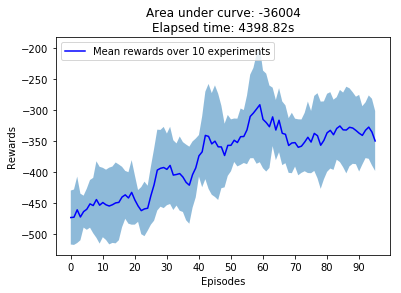

In [0]:
# Current environments: 
# cartpole_env, mountaincar_env, acrobot_env
# Use Acrobot with 50 episodes
# Use Cartpole with 100 episodes
# Test Replay vs PER(prio=1) vs PER(prio=2) ?

run_experiments(PrioritizedReplayMemory, env=acrobot_env, capacity=10000, num_experiments=10, smoothing_factor=5, num_episodes=100, num_hidden=128, batch_size=64, discount_factor=0.8, learn_rate=0.001)